<a href="https://colab.research.google.com/github/edmanft/DL_quantum_metrology/blob/main/Training_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Research Notebook we compare the performance of different preprocessing on the data over 

In [45]:

import joblib
import numpy as np
import pandas as pd
from pandas import DataFrame

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
import seaborn as sns


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import os

In [2]:
"For google colab"
path = "/content/drive/MyDrive/Preterm Birth Challenge 2022"
os.chdir(path)


In [17]:

metadata_df = pd.read_csv('training_data/metadata/metadata.csv') 
alpha_diversity_df = pd.read_csv('training_data/alpha_diversity/alpha_diversity.csv') 
cst_valencia_df = pd.read_csv('training_data/community_state_types/cst_valencia.csv') 

## Preprocess data

In [19]:
#TO DO: Algunos campos pueden decir lo mismo con string distinta, por lo que las podemos considerar distintas 
def apply_one_hot(df:DataFrame, features:list) -> DataFrame: 
    dummies = pd.get_dummies(df[features])
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(features, axis=1)
    return df


#TO DO: algunos campos numericos están puestos como rango, por ejemplo edad: 18_to_28, lo cual se puede trastear
def apply_to_numeric(df:DataFrame, features:list, was_nan_field:bool=True) -> DataFrame: 
    
    if was_nan_field:# TO DO: SOLO DEBERÍA AÑADIRSE EL CAMPO WAS_NAN SI EN ESE CAMPO HABÍA NANs
        nan_names = [f'{x}_was_nan' for x in features]
        df[nan_names] = ~df[features].apply(lambda x: x.astype(str).str.isnumeric())
        
    df[features] = df[features].apply(pd.to_numeric, errors='coerce')
    return df

In [20]:
metadata_df = apply_to_numeric(metadata_df, features=['age'])
metadata_df = apply_one_hot(metadata_df, features=['race',
                                                   'NIH Racial Category',
                                                   'NIH Ethnicity Category'])

cst_valencia_df = apply_one_hot(cst_valencia_df, features=['subCST','CST'])


In [22]:
merged_df = metadata_df.merge(alpha_diversity_df, how='left',on='specimen' )\
                       .merge(cst_valencia_df, how='left',on='specimen')
merged_df

,project,specimen,participant_id,was_term,delivery_wk,collect_wk,age,was_preterm,was_early_preterm,age_was_nan,race_American Indian,race_American Indian or Alaska Native,race_AmericanIndian,race_Asian,race_Asian-Chinese,race_Asian-Japanese,race_Asian-Unspecified,race_Black,race_Black or African American,race_Caucasian,race_Decline,race_Indian,race_More than one race,race_Other,race_Other (Specify below),race_Pacific Islander,race_Unknown,race_White,race_african_american,race_american_indian_or_alaska_native,race_asian,race_black,race_caucasian,race_hispanic_or_latino,race_other,race_white,NIH Racial Category_American Indian or Alaska Native,NIH Racial Category_Asian,NIH Racial Category_Black or African American,NIH Racial Category_Native Hawaiian or Other Pacific Islander,NIH Racial Category_Unknown,NIH Racial Category_White,NIH Ethnicity Category_Hispanic or Latino,NIH Ethnicity Category_Unknown,shannon,inv_simpson,bwpd,phylo_entropy,quadratic,unrooted_pd,rooted_pd,score,I-A_sim,I-B_sim,II_sim,III-A_sim,III-B_sim,IV-A_sim,IV-B_sim,IV-C0_sim,IV-C1_sim,IV-C2_sim,IV-C3_sim,IV-C4_sim,V_sim,subCST_I-A,subCST_I-B,subCST_II,subCST_III-A,subCST_III-B,subCST_IV-A,subCST_IV-B,subCST_IV-C0,subCST_IV-C2,subCST_IV-C4,subCST_V,CST_I,CST_II,CST_III,CST_IV-A,CST_IV-B,CST_IV-C,CST_V
0,A,A00001-05,A00001,True,38.0,33.0,NaN,False,False,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.53935,0.868561,0.002266,0.045526,0.164564,0.805694,0.868561,0.066462,0.144935,0.113105,0.019802,0.014567,0.002000,0.139160,0.265682,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,A,A00002-01,A00002,True,40.0,38.0,NaN,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.96362,1.81277,2.628940,1.318870,0.876314,3.943410,4.14816,0.000772,0.000009,0.000104,0.000451,0.000772,0.000740,0.000172,0.000214,0.000297,0.000051,0.000032,0.000010,0.000191,0.000657,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,A,A00003-02,A00003,True,40.0,30.0,NaN,False,False,True,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.62632,0.001252,0.000002,0.000042,0.001252,0.000009,0.000015,0.000006,0.000020,0.000086,0.000030,0.000036,0.000014,0.000016,0.000071,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,A,A00004-08,A00004,True,40.0,27.0,NaN,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,1.83870,0.996736,0.002449,0.043388,0.046478,0.996736,0.816134,0.053720,0.115648,0.076248,0.017566,0.011676,0.000935,0.122982,0.239510,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,A,A00004-12,A00004,True,40.0,29.0,NaN,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,6.94884,4.07385,2.788960,3.134220,1.219900,15.518500,15.58460,0.957829,0.002385,0.043777,0.047363,0.957829,0.853364,0.057898,0.125207,0.084741,0.017835,0.011887,0.000952,0.129132,0.249143,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,J,J00111-01,J00111,True,40.0,17.0,27.0,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.25993,0.990570,0.004976,0.045129,0.045368,0.990570,0.778906,0.051016,0.109562,0.071449,0.017204,0.011538,0.000925,0.118074,0.230769,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3574,J,J00112-01,J00112,True,39.0,19.0,27.0,False,False,False,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.00149,1.00108,0.008313,0.002881,0.002078,0.008313,1.93897,0.963321,0.963321,0.953175,0.005574,0.012477,0.114151,0.002268,0.012967,0.047935,0.006936,0.0

Split data into features and target variable:

In [24]:
X = merged_df.drop(['project',
                    'specimen',
                    'participant_id',
                    'was_term',
                    'was_preterm',
                    'was_early_preterm',
                    'delivery_wk',
                    'collect_wk'], axis=1)

y_1 = merged_df['was_preterm']
y_2 = merged_df['delivery_wk'] 
#TO DO: puede ser interesante predecir la delivery_wk y luego construir el was_preterm

## Baseline model

In [27]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                     ('std_scaler', StandardScaler()),
                     ('random_forest', RandomForestClassifier())])
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

score=cross_val_score(pipeline, X, y_1, cv=cv, scoring = "roc_auc")
print(f"{score}\n mean:{np.mean(score)}")


[0.7315506  0.74669089 0.7543925  0.74969788 0.73163888]
 mean:0.7427941506818737


# Further feature engineering

## Race

There are statistical differences in the delivery week among races

In [56]:
metadata_df = pd.read_csv('training_data/metadata/metadata.csv') 
alpha_diversity_df = pd.read_csv('training_data/alpha_diversity/alpha_diversity.csv') 
cst_valencia_df = pd.read_csv('training_data/community_state_types/cst_valencia.csv') 
original_df = metadata_df.merge(alpha_diversity_df, how='left',on='specimen' )\
                       .merge(cst_valencia_df, how='left',on='specimen')
original_df

,project,specimen,participant_id,was_term,delivery_wk,collect_wk,race,age,NIH Racial Category,NIH Ethnicity Category,was_preterm,was_early_preterm,shannon,inv_simpson,bwpd,phylo_entropy,quadratic,unrooted_pd,rooted_pd,CST,subCST,score,I-A_sim,I-B_sim,II_sim,III-A_sim,III-B_sim,IV-A_sim,IV-B_sim,IV-C0_sim,IV-C1_sim,IV-C2_sim,IV-C3_sim,IV-C4_sim,V_sim
0,A,A00001-05,A00001,True,38.0,33.0,American Indian,Unknown,American Indian or Alaska Native,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.53935,III,III-B,0.868561,0.002266,0.045526,0.164564,0.805694,0.868561,0.066462,0.144935,0.113105,0.019802,0.014567,0.002000,0.139160,0.265682
1,A,A00002-01,A00002,True,40.0,38.0,White,Unknown,White,Unknown,False,False,1.96362,1.81277,2.628940,1.318870,0.876314,3.943410,4.14816,III,III-A,0.000772,0.000009,0.000104,0.000451,0.000772,0.000740,0.000172,0.000214,0.000297,0.000051,0.000032,0.000010,0.000191,0.000657
2,A,A00003-02,A00003,True,40.0,30.0,Asian-Japanese,Unknown,Asian,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.62632,II,II,0.001252,0.000002,0.000042,0.001252,0.000009,0.000015,0.000006,0.000020,0.000086,0.000030,0.000036,0.000014,0.000016,0.000071
3,A,A00004-08,A00004,True,40.0,27.0,White,Unknown,White,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,1.83870,III,III-A,0.996736,0.002449,0.043388,0.046478,0.996736,0.816134,0.053720,0.115648,0.076248,0.017566,0.011676,0.000935,0.122982,0.239510
4,A,A00004-12,A00004,True,40.0,29.0,White,Unknown,White,Unknown,False,False,6.94884,4.07385,2.788960,3.134220,1.219900,15.518500,15.58460,III,III-A,0.957829,0.002385,0.043777,0.047363,0.957829,0.853364,0.057898,0.125207,0.084741,0.017835,0.011887,0.000952,0.129132,0.249143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,J,J00111-01,J00111,True,40.0,17.0,Caucasian,27,White,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.25993,III,III-A,0.990570,0.004976,0.045129,0.045368,0.990570,0.778906,0.051016,0.109562,0.071449,0.017204,0.011538,0.000925,0.118074,0.230769
3574,J,J00112-01,J00112,True,39.0,19.0,Caucasian,27,White,Unknown,False,False,1.00149,1.00108,0.008313,0.002881,0.002078,0.008313,1.93897,I,I-A,0.963321,0.963321,0.953175,0.005574,0.012477,0.114151,0.002268,0.012967,0.047935,0.006936,0.027783,0.002759,0.009767,0.109528
3575,J,J00113-01,J00113,True,41.0,16.0,Caucasian,32,White,Unknown,False,False,3.05187,2.53112,3.399690,2.177080,1.180320,6.952930,7.15767,III,III-B,0.522828,0.004978,0.035157,0.034497,0.512631,0.522828,0.046678,0.099839,0.071858,0.013059,0.008936,0.000738,0.096630,0.178766
3576,J,J00115-01,J00115,True,42.0,18.0,Caucasian,35,White,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.26097,III,III-A,0.994335,0.028987,0.070567,0.046304,0.994335,0.817074,0.052802,0.114029,0.076738,0.017752,0.012944,0.001055,0.121606,0.238546


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

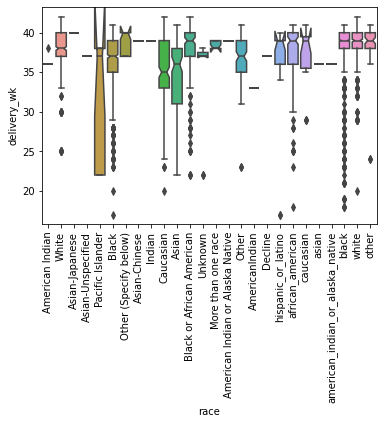

In [50]:
ax = sns.boxplot(x="race", y="delivery_wk", data=original_df, notch = True)
plt.xticks(rotation=90)

The data is messy, we have to collapse classes that mean the same and probably eliminate those with too few subjects

In [57]:
Counter(original_df["race"])




Counter({'American Indian': 21,
         'American Indian or Alaska Native': 1,
         'AmericanIndian': 3,
         'Asian': 136,
         'Asian-Chinese': 6,
         'Asian-Japanese': 1,
         'Asian-Unspecified': 5,
         'Black': 758,
         'Black or African American': 144,
         'Caucasian': 208,
         'Decline': 6,
         'Indian': 5,
         'More than one race': 10,
         'Other': 114,
         'Other (Specify below)': 30,
         'Pacific Islander': 11,
         'Unknown': 19,
         'White': 419,
         'african_american': 183,
         'american_indian_or_alaska_native': 2,
         'asian': 1,
         'black': 1078,
         'caucasian': 15,
         'hispanic_or_latino': 15,
         'other': 64,
         'white': 323})

In [66]:
replace_dict = {'American Indian or Alaska Native' : 'American Indian',
                'american_indian_or_alaska_native' : 'American Indian',
                'AmericanIndian' : 'American Indian',
                'Asian-Chinese': 'Asian',
                'Asian-Japanese': 'Asian',
                'Asian-Unspecified':'Asian',
                 'asian': 'Asian',
                'Black or African American' : 'Black',
                'Other (Specify below)' : 'Other',
                'More than one race' : 'Other',
                'other': 'Other',
                'black': 'Black',
                'white': 'White' }




dict_keys(['American Indian or Alaska Native', 'american_indian_or_alaska_native', 'AmericanIndian', 'Asian-Chinese', 'Asian-Japanese', 'Asian-Unspecified', 'asian', 'Black or African American', 'Other (Specify below)', 'More than one race', 'other', 'black', 'white'])

In [77]:
corrected_df = original_df.copy()
corrected_df["race"] = corrected_df["race"].apply(lambda x: replace_dict[x] if (x in replace_dict.keys()) else x)
corrected_df

,project,specimen,participant_id,was_term,delivery_wk,collect_wk,race,age,NIH Racial Category,NIH Ethnicity Category,was_preterm,was_early_preterm,shannon,inv_simpson,bwpd,phylo_entropy,quadratic,unrooted_pd,rooted_pd,CST,subCST,score,I-A_sim,I-B_sim,II_sim,III-A_sim,III-B_sim,IV-A_sim,IV-B_sim,IV-C0_sim,IV-C1_sim,IV-C2_sim,IV-C3_sim,IV-C4_sim,V_sim
0,A,A00001-05,A00001,True,38.0,33.0,American Indian,Unknown,American Indian or Alaska Native,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.53935,III,III-B,0.868561,0.002266,0.045526,0.164564,0.805694,0.868561,0.066462,0.144935,0.113105,0.019802,0.014567,0.002000,0.139160,0.265682
1,A,A00002-01,A00002,True,40.0,38.0,White,Unknown,White,Unknown,False,False,1.96362,1.81277,2.628940,1.318870,0.876314,3.943410,4.14816,III,III-A,0.000772,0.000009,0.000104,0.000451,0.000772,0.000740,0.000172,0.000214,0.000297,0.000051,0.000032,0.000010,0.000191,0.000657
2,A,A00003-02,A00003,True,40.0,30.0,Asian,Unknown,Asian,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.62632,II,II,0.001252,0.000002,0.000042,0.001252,0.000009,0.000015,0.000006,0.000020,0.000086,0.000030,0.000036,0.000014,0.000016,0.000071
3,A,A00004-08,A00004,True,40.0,27.0,White,Unknown,White,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,1.83870,III,III-A,0.996736,0.002449,0.043388,0.046478,0.996736,0.816134,0.053720,0.115648,0.076248,0.017566,0.011676,0.000935,0.122982,0.239510
4,A,A00004-12,A00004,True,40.0,29.0,White,Unknown,White,Unknown,False,False,6.94884,4.07385,2.788960,3.134220,1.219900,15.518500,15.58460,III,III-A,0.957829,0.002385,0.043777,0.047363,0.957829,0.853364,0.057898,0.125207,0.084741,0.017835,0.011887,0.000952,0.129132,0.249143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,J,J00111-01,J00111,True,40.0,17.0,Caucasian,27,White,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.25993,III,III-A,0.990570,0.004976,0.045129,0.045368,0.990570,0.778906,0.051016,0.109562,0.071449,0.017204,0.011538,0.000925,0.118074,0.230769
3574,J,J00112-01,J00112,True,39.0,19.0,Caucasian,27,White,Unknown,False,False,1.00149,1.00108,0.008313,0.002881,0.002078,0.008313,1.93897,I,I-A,0.963321,0.963321,0.953175,0.005574,0.012477,0.114151,0.002268,0.012967,0.047935,0.006936,0.027783,0.002759,0.009767,0.109528
3575,J,J00113-01,J00113,True,41.0,16.0,Caucasian,32,White,Unknown,False,False,3.05187,2.53112,3.399690,2.177080,1.180320,6.952930,7.15767,III,III-B,0.522828,0.004978,0.035157,0.034497,0.512631,0.522828,0.046678,0.099839,0.071858,0.013059,0.008936,0.000738,0.096630,0.178766
3576,J,J00115-01,J00115,True,42.0,18.0,Caucasian,35,White,Unknown,False,False,1.00000,1.00000,0.000000,-0.000000,0.000000,0.000000,2.26097,III,III-A,0.994335,0.028987,0.070567,0.046304,0.994335,0.817074,0.052802,0.114029,0.076738,0.017752,0.012944,0.001055,0.121606,0.238546


In [78]:
Counter(corrected_df["race"])

Counter({'American Indian': 27,
         'Asian': 149,
         'Black': 1980,
         'Caucasian': 208,
         'Decline': 6,
         'Indian': 5,
         'Other': 218,
         'Pacific Islander': 11,
         'Unknown': 19,
         'White': 742,
         'african_american': 183,
         'caucasian': 15,
         'hispanic_or_latino': 15})

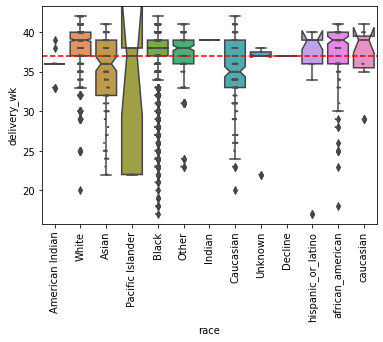

In [84]:
ax = sns.boxplot(x="race", y="delivery_wk", data=corrected_df, notch = True)
sns.stripplot(x="race", y="delivery_wk", data=corrected_df,
              size=2, color=".3", linewidth=0)
plt.xticks(rotation=90)
plt.axhline(37, linestyle = "--", color = "red")

### Evaluation
Let's see if the performance improves

In [85]:
corrected_df = apply_to_numeric(corrected_df, features=['age'])
corrected_df = apply_one_hot(corrected_df, features=['race',
                                                   'NIH Racial Category',
                                                   'NIH Ethnicity Category'])

corrected_df = apply_one_hot(corrected_df, features=['subCST','CST'])

In [86]:
X = corrected_df.drop(['project',
                    'specimen',
                    'participant_id',
                    'was_term',
                    'was_preterm',
                    'was_early_preterm',
                    'delivery_wk',
                    'collect_wk'], axis=1)

y_1 = corrected_df['was_preterm']
y_2 = corrected_df['delivery_wk'] 
#TO DO: puede ser interesante predecir la delivery_wk y luego construir el was_preterm

In [87]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                     ('std_scaler', StandardScaler()),
                     ('random_forest', RandomForestClassifier())])
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

score=cross_val_score(pipeline, X, y_1, cv=cv, scoring = "roc_auc")
print(f"{score}\n mean:{np.mean(score)}")

[0.71076527 0.7480956  0.75545887 0.74183219 0.72858353]
 mean:0.7369470920338845
